# Model Comparison — Combined UCI Heart Dataset

This notebook compares multiple models trained on the **combined_uci_heart** dataset:

- Logistic Regression  
- XGBoost  
- Support Vector Machine (SVM)  
- Feed-forward Neural Network (PyTorch)  
- Transformer-based Tabular Model (PyTorch)  

We use:
- Metrics saved from previous training runs (`experiments/results/*_combined_uci_heart_metrics.csv`)  
- Optional 10-fold cross-validation for classical models to obtain mean ± std performance.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

dataset_name = "combined_uci_heart"

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
RESULTS_DIR = os.path.join(BASE_DIR, "experiments", "results")

print("Base dir:", BASE_DIR)
print("Results dir:", RESULTS_DIR)


Base dir: c:\Users\user\CardioVescular_Disease_prediction
Results dir: c:\Users\user\CardioVescular_Disease_prediction\experiments\results


## Load Saved Metrics for Each Model

We parse the per-model `*_metrics.csv` files produced by the training scripts and extract approximate Accuracy and AUC-like summaries.  
*(Note: the CSVs come from `classification_report`; for proper AUC we prefer to recompute directly, but this gives a quick overview.)*


In [2]:
metrics_files = [f for f in os.listdir(RESULTS_DIR) if f.endswith(f"{dataset_name}_metrics.csv")]
metrics_files


['logistic_regression_combined_uci_heart_metrics.csv',
 'neural_network_combined_uci_heart_metrics.csv',
 'svm_combined_uci_heart_metrics.csv',
 'transformer_combined_uci_heart_metrics.csv',
 'xgboost_combined_uci_heart_metrics.csv']

In [3]:
rows = []
for file in metrics_files:
    path = os.path.join(RESULTS_DIR, file)
    df = pd.read_csv(path, index_col=0)
    model_name = file.replace(f"_{dataset_name}_metrics.csv", "")

    # Heuristics: accuracy row exists; macro avg f1 often correlates with AUC-like behavior
    acc = df.loc["accuracy", "f1-score"] if "accuracy" in df.index else np.nan
    macro_f1 = df.loc["macro avg", "f1-score"] if "macro avg" in df.index else np.nan

    rows.append({
        "Model": model_name,
        "Accuracy (approx)": acc,
        "Macro F1": macro_f1,
    })

metrics_df = pd.DataFrame(rows).sort_values("Accuracy (approx)", ascending=False)
metrics_df


,Model,Accuracy (approx),Macro F1
4,xgboost,0.833333,0.830317
0,logistic_regression,0.816667,0.814137
2,svm,0.816667,0.814137
1,neural_network,0.800000,0.797980
3,transformer,0.750000,0.737686


## Bar Plots — Approximate Accuracy and Macro F1


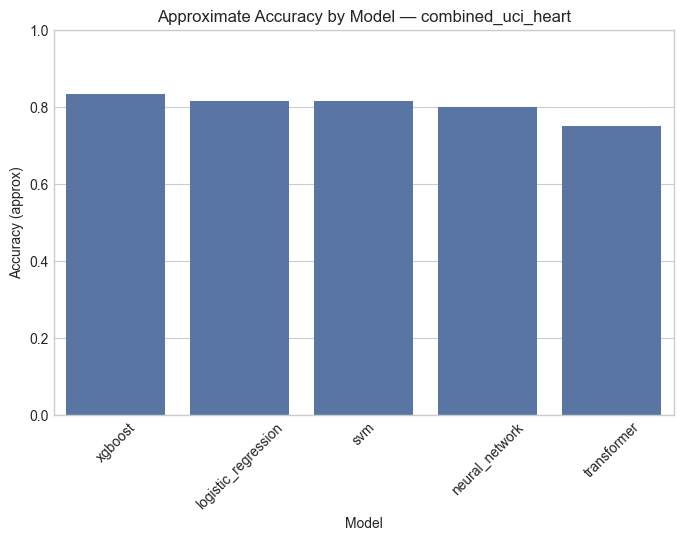

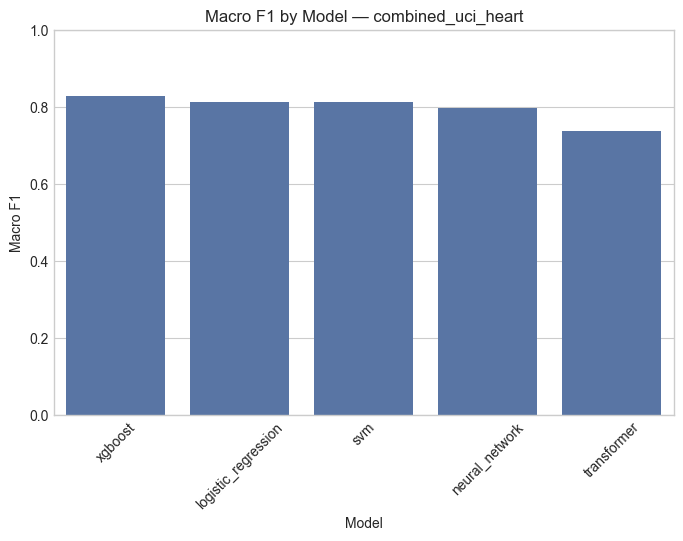

In [4]:
plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x="Model", y="Accuracy (approx)")
plt.title(f"Approximate Accuracy by Model — {dataset_name}")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x="Model", y="Macro F1")
plt.title(f"Macro F1 by Model — {dataset_name}")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


## 10-fold Cross-Validation (Classical Models)

To obtain **more realistic performance estimates**, we run 10-fold stratified cross-validation on the combined dataset for:

- Logistic Regression  
- SVM  
- XGBoost  

We recompute Accuracy and ROC AUC from scratch here.


In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import joblib

# Load full processed dataset
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")
X_path = os.path.join(PROCESSED_DIR, f"{dataset_name}_X.joblib")
y_path = os.path.join(PROCESSED_DIR, f"{dataset_name}_y.joblib")

X = joblib.load(X_path)
y = joblib.load(y_path)

# Densify if needed
if hasattr(X, "toarray"):
    X = X.toarray()

print("Data for CV:", X.shape, y.shape)

models = {
    "logreg_cv": LogisticRegression(max_iter=1000, solver="lbfgs"),
    "svm_cv": SVC(kernel="rbf", probability=True, C=1.0, gamma="scale"),
    "xgboost_cv": XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
        
    ),
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_results = []

for name, model in models.items():
    accs = []
    aucs = []
    print(f"\n🔁 10-fold CV for {name}")

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        accs.append(accuracy_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_proba))

        print(f"  Fold {fold}: acc={accs[-1]:.3f}, auc={aucs[-1]:.3f}")

    cv_results.append({
        "Model": name,
        "CV_Accuracy_mean": np.mean(accs),
        "CV_Accuracy_std": np.std(accs),
        "CV_AUC_mean": np.mean(aucs),
        "CV_AUC_std": np.std(aucs),
    })

cv_df = pd.DataFrame(cv_results)
cv_df


Data for CV: (299, 13) (299,)

🔁 10-fold CV for logreg_cv
  Fold 1: acc=0.767, auc=0.799
  Fold 2: acc=0.933, auc=0.996
  Fold 3: acc=0.933, auc=0.964
  Fold 4: acc=0.733, auc=0.875
  Fold 5: acc=0.867, auc=0.969
  Fold 6: acc=0.733, auc=0.795
  Fold 7: acc=0.867, auc=0.946
  Fold 8: acc=0.800, auc=0.902
  Fold 9: acc=0.967, auc=0.987
  Fold 10: acc=0.724, auc=0.774

🔁 10-fold CV for svm_cv
  Fold 1: acc=0.767, auc=0.786
  Fold 2: acc=0.933, auc=0.987
  Fold 3: acc=0.900, auc=0.951
  Fold 4: acc=0.700, auc=0.875
  Fold 5: acc=0.800, auc=0.915
  Fold 6: acc=0.667, auc=0.812
  Fold 7: acc=0.900, auc=0.951
  Fold 8: acc=0.800, auc=0.888
  Fold 9: acc=0.933, auc=0.955
  Fold 10: acc=0.793, auc=0.851

🔁 10-fold CV for xgboost_cv
  Fold 1: acc=0.733, auc=0.795
  Fold 2: acc=0.833, auc=0.982
  Fold 3: acc=0.867, auc=0.946
  Fold 4: acc=0.700, auc=0.879
  Fold 5: acc=0.800, auc=0.920
  Fold 6: acc=0.700, auc=0.723
  Fold 7: acc=0.900, auc=0.951
  Fold 8: acc=0.800, auc=0.906
  Fold 9: acc=0.93

,Model,CV_Accuracy_mean,CV_Accuracy_std,CV_AUC_mean,CV_AUC_std
0,logreg_cv,0.832414,0.088017,0.900618,0.080878
1,svm_cv,0.819310,0.089868,0.897150,0.063069
2,xgboost_cv,0.795632,0.083524,0.883860,0.079127


## Cross-Validation Summary


ValueError: 'yerr' (shape: (3,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

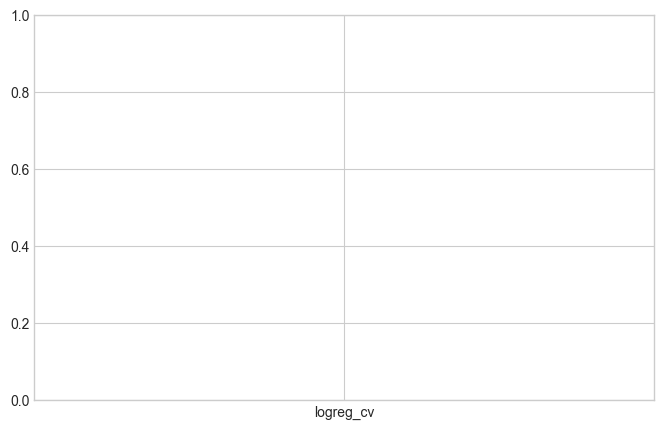

In [6]:
plt.figure(figsize=(8, 5))
sns.barplot(data=cv_df, x="Model", y="CV_Accuracy_mean", yerr=cv_df["CV_Accuracy_std"])
plt.title(f"10-fold CV Accuracy — {dataset_name}")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=cv_df, x="Model", y="CV_AUC_mean", yerr=cv_df["CV_AUC_std"])
plt.title(f"10-fold CV AUC — {dataset_name}")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()


## Feature Importance (XGBoost)

We fit XGBoost once on the full dataset and inspect feature importances (gain).  
Note: feature indices here correspond to processed/engineered features, not original raw column names.


<Figure size 800x600 with 0 Axes>

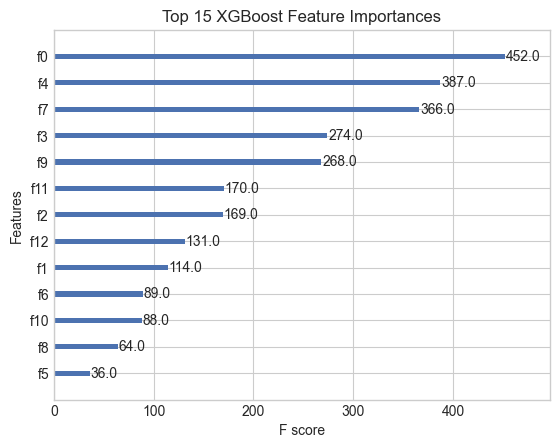

In [9]:
from xgboost import plot_importance

xgb_full = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    
)
xgb_full.fit(X, y)

plt.figure(figsize=(8, 6))
plot_importance(xgb_full, max_num_features=15)
plt.title("Top 15 XGBoost Feature Importances")
plt.show()
